In [1]:
import numpy as np
import os
import pandas as pd
from scipy.stats import median_abs_deviation, chi2
import seaborn as sns
import statsmodels.api as sm

# Data preprocessing

In [2]:
df_iceberg = pd.read_excel('ICEBERG data/export_iceberg_31052021.xlsx', sheet_name='Neuropsy')

df_pca_iceberg = pd.read_csv('Ancestry/Genetic ancestry (principal components) - ICEBERG.csv', index_col=0)

df_grs_iceberg = pd.read_csv('LDpred2 - Results/GRS - ICEBERG.csv', index_col=0)
df_grs_iceberg = df_grs_iceberg.sub(df_grs_iceberg.mean(axis=0)).div(df_grs_iceberg.std(axis=0))

df_gba_iceberg = pd.read_csv('ICEBERG data/GBA/ICEBERG - GBA status.csv', index_col=0)
df_apoe_iceberg = pd.read_csv('ICEBERG data/ApoE e4/APOE SNP data.csv', index_col=0)

In [3]:
df_iceberg_mlm = df_iceberg[
    ['num_sujet', 'redcap_event_name', 'sexe', 'statut_inclusion',
     'date_visite', 'ddn_m', 'ddn_a', 'total_moca']
].copy()

# Keep only subjects recruited as PD subjects
df_iceberg_mlm = df_iceberg_mlm[df_iceberg_mlm['statut_inclusion'] == 4.0]

# Rename some columns
df_iceberg_mlm = df_iceberg_mlm.rename(
    columns={'num_sujet': 'PATNO', 'redcap_event_name': 'Visit', 'sexe': 'Sex', 'total_moca': 'MoCA'}
)

# Set PATNO column as index
df_iceberg_mlm = df_iceberg_mlm.set_index('PATNO')

# Intercept
df_iceberg_mlm['Intercept'] = 1.

# Reformat some columns
df_iceberg_mlm['Visit'] = df_iceberg_mlm['Visit'].str[1].astype('int64')
df_iceberg_mlm['Sex'] = df_iceberg_mlm['Sex'] - 1.0

# Education level
df_iceberg_mlm[[f'education_level_{i}' for i in range(3, 8)]] = pd.get_dummies(pd.read_excel(
    'ICEBERG data/export_iceberg_31052021.xlsx', sheet_name='Générales', usecols=['num_sujet', 'niv_etud']
).groupby('num_sujet')['niv_etud'].mean().astype('int64'), prefix='education_level', drop_first=True)

# Date of PD diagnosis
df_iceberg_mlm['date_diagnosis'] = pd.read_excel(
    'ICEBERG data/export_iceberg_31052021.xlsx', sheet_name='Générales',
    usecols=['num_sujet', 'date_diag']
).groupby('num_sujet')['date_diag'].apply(lambda x: x.iloc[0])

# Time from PD onset
df_iceberg_mlm['Time from PD onset'] = (
    df_iceberg_mlm['date_visite'] - df_iceberg_mlm['date_diagnosis']
).astype('timedelta64[D]') / 365.25

# Age at PD diagnosis
df_iceberg_mlm['Age at PD diagnosis'] = (
    df_iceberg_mlm['date_diagnosis']
    -
    pd.to_datetime(
        '01/' + 
        df_iceberg_mlm.loc[df_iceberg_mlm['Visit'] == 0, 'ddn_m'].astype(int).astype(str) + 
        '/' + 
        df_iceberg_mlm.loc[df_iceberg_mlm['Visit'] == 0, 'ddn_a'].astype(int).astype(str)
    )
).astype('timedelta64[D]') / 365.25

# APOE and GBA
df_iceberg_mlm[['rs429358-C', 'rs7412-C']] = df_apoe_iceberg
df_iceberg_mlm[['Number of severe GBA mutations', 'Number of mild GBA mutations',
                'Number of undetermined GBA mutations']] = df_gba_iceberg

# Genetic ancestry
df_iceberg_mlm[[f'PC{i}' for i in range(1, 5)]] = df_pca_iceberg[[f'PC{i}' for i in range(1, 5)]]

# Genetic risk scores
df_iceberg_mlm[df_grs_iceberg.columns] = df_grs_iceberg

# Reset index and keep columns of interest
df_iceberg_mlm = df_iceberg_mlm.reset_index()[
    ['PATNO', 'Visit', 'Intercept', 'Sex', 'Age at PD diagnosis', 'Time from PD onset', 'MoCA'] +
    [f'education_level_{i}' for i in range(3, 8)] +
    ['Number of mild GBA mutations', 'Number of undetermined GBA mutations', 'rs429358-C', 'rs7412-C'] +
    [f'PC{i}' for i in range(1, 5)] + 
    list(df_grs_iceberg.columns)
]

# Drop subjects with no genetic data
df_iceberg_mlm = df_iceberg_mlm[~df_iceberg_mlm[df_grs_iceberg.columns].isna().all(axis=1)]

# Drop visits with no MoCA
df_iceberg_mlm = df_iceberg_mlm[~df_iceberg_mlm['MoCA'].isna()]

# Make a copy to get a de-fragmented DataFrame
df_iceberg_mlm = df_iceberg_mlm.copy()

# Check that there is no missing value
assert not df_iceberg_mlm.isna().any().any()

/Users/johann.faouzi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


# Main analyses

The reviewers asked for two main changes in the analyses:
* Replacing the `Visit` variable with `Time since PD onset` variable
* Adding an `Education level` variable as a covariate
* Plotting the residuals to check for normality
* Checking if the combined model is significantly better than each individual model

In [4]:
def run_statistical_analyses_updated(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores
        
    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value
    
    """

    # Create an empty list to save all the results
    df_res = []
    
    # Create an empty dictionary to save the residuals
    residuals = {}
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset'] +
            [f'education_level_{i}' for i in range(3, 8)] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358-C', 'rs7412-C'] +
            ['Number of mild GBA mutations', 'Number of undetermined GBA mutations'] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['MoCA'], exog=df_copy[exog], groups=df_copy['PATNO']
        )
        model = model.fit(maxiter=2000)

        df_res.append([
            model.params[col],
            model.conf_int().loc[col, 0],
            model.conf_int().loc[col, 1],
            model.pvalues[col]
        ])
        
        # print(model.summary())
        
        # Save the residuals
        residuals[col] = df_copy['MoCA'] - model.fittedvalues

    # Transform the list into a DataFrame
    df_res = pd.DataFrame(
        df_res,
        index=[col for col in df.columns if col.startswith('GRS__')],
        columns=('Coefficient', 'Lower bound (95% CI)', 'Upper bound (95% CI)', 'p-value')
    )
    
    return df_res, residuals

In [11]:
def plot_residuals(residuals, col, title='', fname=None):
    ax = sns.histplot(residuals[col], stat='density', kde=True)
    _ = ax.set_ylabel('');
    _ = ax.set_xlabel('Residuals')
    _ = ax.set_title(title)
    if fname:
        ax.savefig(fname)

In [6]:
def compare_combined_prs_vs_individual_prs(df, grs_cols):
    """Likelihood ratio tests."""
    
    # Save the models
    models = {}
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each individual PRS
    for col in grs_cols:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset'] +
            [f'education_level_{i}' for i in range(3, 8)] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358-C', 'rs7412-C'] +
            ['Number of mild GBA mutations', 'Number of undetermined GBA mutations'] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['MoCA'], exog=df_copy[exog], groups=df_copy['PATNO']
        )
        model = model.fit(maxiter=2000, reml=False)

        # print(model.summary())
        
        # Save the residuals
        models[col] = model

    # Combined PRS
    exog = (
        ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset'] +
        [f'education_level_{i}' for i in range(3, 8)] +
        [f'PC{i}' for i in range(1, 5)] +
        ['rs429358-C', 'rs7412-C'] +
        ['Number of mild GBA mutations', 'Number of undetermined GBA mutations'] +
        grs_cols
    )

    model_combined = sm.MixedLM(
        endog=df_copy['MoCA'], exog=df_copy[exog], groups=df_copy['PATNO']
    )
    model_combined = model_combined.fit(maxiter=2000, reml=False)

    # print(model_combined.summary())

    pvalues = {
        col: 1 - chi2(df=len(grs_cols) - 1).cdf(-2 * (models[col].llf - model_combined.llf))
        for col in grs_cols
    }
    
    return pvalues

# Additional analyses

The reviewers have asked for two additional analyses in particular:
* Adding interactions terms between (i) the PRS variable and (ii) each APOE and GBA variable.
* Running the analyses without the APOE and GBA variables as covariates.

## Interactions terms

In [7]:
def run_statistical_analyses_with_interaction_terms(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores

    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value

    """

    # Create an empty list to save all the results
    df_res = []
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Define APOE and GBA variable names
    apoe_gba_columns = [
        'Number of mild GBA mutations',
        'Number of undetermined GBA mutations',
        'rs429358-C',
        'rs7412-C'
    ]
    interactions_columns = [f'Interaction {i}' for i in range(1, len(apoe_gba_columns) + 1)]
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:
        
        # Add interaction terms
        df_copy[interactions_columns] = (
            df_copy[apoe_gba_columns].mul(df_copy[col], axis=0)
        )

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset'] +
            [f'education_level_{i}' for i in range(3, 8)] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358-C', 'rs7412-C'] +
            ['Number of mild GBA mutations', 'Number of undetermined GBA mutations'] +
            interactions_columns +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['MoCA'], exog=df_copy[exog], groups=df_copy['PATNO']
        )
        model = model.fit(maxiter=2000)

        df_temp = pd.DataFrame(pd.concat([
            model.params[[col] + interactions_columns],
            model.conf_int().loc[[col] + interactions_columns, 0],
            model.conf_int().loc[[col] + interactions_columns, 1],
            model.pvalues[[col] + interactions_columns]
        ])).T
        df_temp.columns = pd.MultiIndex.from_product((
            ['Effect size', 'Lower bound (95%-CI)', 'Upper bound (95%-CI)', 'p-value'],
            ['GRS'] + interactions_columns
        ))
        df_res.append(df_temp)
        
        # print(model.summary())

    # Transform the list into a DataFrame
    df_res = pd.concat(df_res, axis=0)
    df_res.index = grs_col

    return df_res

## Without APOE and GBA covariates

In [8]:
def run_statistical_analyses_without_apoe_and_gba(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores

    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value

    """

    # Create an empty list to save all the results
    df_res = []
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset'] +
            [f'education_level_{i}' for i in range(3, 8)] +
            [f'PC{i}' for i in range(1, 5)] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['MoCA'], exog=df_copy[exog], groups=df_copy['PATNO']
        )
        model = model.fit(maxiter=2000)

        df_res.append([
            model.params[col],
            model.conf_int().loc[col, 0],
            model.conf_int().loc[col, 1],
            model.pvalues[col]
        ])
        
        # print(model.summary())

    # Transform the list into a DataFrame
    df_res = pd.DataFrame(
        df_res,
        index=[col for col in df.columns if col.startswith('GRS__')],
        columns=('Coefficient', 'Lower bound (95% CI)', 'Upper bound (95% CI)', 'p-value')
    )

    return df_res

### Main analyses

In [9]:
df_res, residuals = run_statistical_analyses_updated(df_iceberg_mlm)

In [10]:
df_res[df_res['p-value'] < 0.05]

,Coefficient,Lower bound (95% CI),Upper bound (95% CI),p-value
GRS__davies_2018__reaction_time.txt,-0.349431,-0.638146,-0.060716,0.017686
GRS__grasby_2020__mean_entorhinal_surfavg.txt,0.402852,0.090846,0.714859,0.011385
GRS__grasby_2020__mean_medialorbitofrontal_thickavg.txt,-0.365795,-0.674688,-0.056903,0.020286
GRS__grasby_2020__mean_middletemporal_thickavg.txt,0.358009,0.022432,0.693585,0.036530
GRS__grasby_2020__mean_pericalcarine_thickavg.txt,0.358324,0.046110,0.670537,0.024485
GRS__grasby_2020__mean_superiorparietal_surfavg.txt,-0.350113,-0.657607,-0.042619,0.025640
GRS__grasby_2020__mean_transversetemporal_surfavg.txt,-0.443417,-0.771443,-0.115391,0.008063
GRS__kunkle_2019__alzheimer_disease.txt,-0.489271,-0.947936,-0.030606,0.036550
GRS__satizabal_2019__subcortical_volume_caudate.txt,-0.443523,-0.757432,-0.129613,0.005619
GRS__satizabal_2019__subcortical_volume_thalamus.txt,0.301008,0.007227,0.594789,0.044625


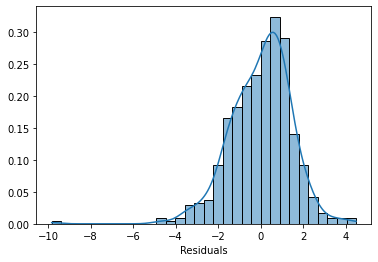

In [11]:
plot_residuals(residuals, 'GRS__savage_2018__intelligence.txt')

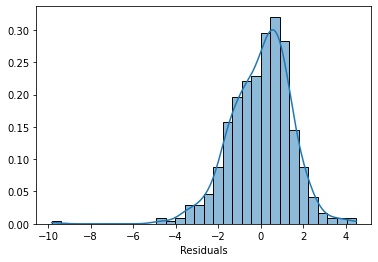

In [12]:
plot_residuals(residuals, 'GRS__lee_2018__cognitive_performance.txt')

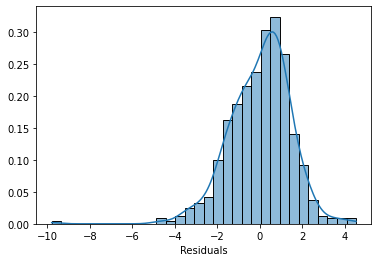

In [13]:
plot_residuals(residuals, 'GRS__davies_2016__reasoning.txt')

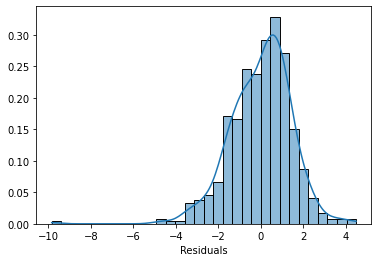

In [14]:
plot_residuals(residuals, 'GRS__lee_2018__educational_attainment.txt')

### With interaction terms

In [15]:
df_res_with_interaction_terms = run_statistical_analyses_with_interaction_terms(df_iceberg_mlm)

In [16]:
df_res_with_interaction_terms[(df_res_with_interaction_terms['p-value'] < 0.0001).any(axis=1)]

Empty DataFrame
Columns: [(Effect size, GRS), (Effect size, Interaction 1), (Effect size, Interaction 2), (Effect size, Interaction 3), (Effect size, Interaction 4), (Lower bound (95%-CI), GRS), (Lower bound (95%-CI), Interaction 1), (Lower bound (95%-CI), Interaction 2), (Lower bound (95%-CI), Interaction 3), (Lower bound (95%-CI), Interaction 4), (Upper bound (95%-CI), GRS), (Upper bound (95%-CI), Interaction 1), (Upper bound (95%-CI), Interaction 2), (Upper bound (95%-CI), Interaction 3), (Upper bound (95%-CI), Interaction 4), (p-value, GRS), (p-value, Interaction 1), (p-value, Interaction 2), (p-value, Interaction 3), (p-value, Interaction 4)]
Index: []

### Without APOE and GBA covariates

In [17]:
df_res_without_apoe_and_gba = run_statistical_analyses_without_apoe_and_gba(df_iceberg_mlm)

In [18]:
df_res_without_apoe_and_gba[df_res_without_apoe_and_gba['p-value'] < 0.0005]

,Coefficient,Lower bound (95% CI),Upper bound (95% CI),p-value


### Combined PRS vs individual PRS

In [19]:
compare_combined_prs_vs_individual_prs(
    df_iceberg_mlm, [
        'GRS__savage_2018__intelligence.txt',
        'GRS__lee_2018__cognitive_performance.txt',
        'GRS__davies_2016__reasoning.txt',
        'GRS__lee_2018__educational_attainment.txt'
    ]
)

{'GRS__savage_2018__intelligence.txt': 0.20863030971640983,
 'GRS__lee_2018__cognitive_performance.txt': 0.18094485609759725,
 'GRS__davies_2016__reasoning.txt': 0.3858851677749061,
 'GRS__lee_2018__educational_attainment.txt': 0.6157572345194562}

### Correlations

In [20]:
cognitive_phenotypes = [
    'GRS__davies_2016__reasoning.txt',
    'GRS__lee_2018__cognitive_performance.txt',
    'GRS__lee_2018__educational_attainment.txt',
    'GRS__savage_2018__intelligence.txt'
]

df_iceberg_mlm[cognitive_phenotypes].corr()

,GRS__davies_2016__reasoning.txt,GRS__lee_2018__cognitive_performance.txt,GRS__lee_2018__educational_attainment.txt,GRS__savage_2018__intelligence.txt
GRS__davies_2016__reasoning.txt,1.000000,0.484086,0.255756,0.451412
GRS__lee_2018__cognitive_performance.txt,0.484086,1.000000,0.441698,0.753636
GRS__lee_2018__educational_attainment.txt,0.255756,0.441698,1.000000,0.504430
GRS__savage_2018__intelligence.txt,0.451412,0.753636,0.504430,1.000000


# Save results

In [21]:
df_res.head()

,Coefficient,Lower bound (95% CI),Upper bound (95% CI),p-value
GRS__adams_2016__intracranial_volume.txt,-0.074599,-0.436626,0.287429,0.686310
GRS__chia_2021__lewy_body_dementia.txt,-0.097165,-0.555894,0.361565,0.678035
GRS__davies_2016__memory_performance.txt,0.094093,-0.203329,0.391515,0.535219
GRS__davies_2016__reasoning.txt,0.208958,-0.086546,0.504461,0.165766
GRS__davies_2018__reaction_time.txt,-0.349431,-0.638146,-0.060716,0.017686


In [22]:
df_res_without_apoe_and_gba.head()

,Coefficient,Lower bound (95% CI),Upper bound (95% CI),p-value
GRS__adams_2016__intracranial_volume.txt,0.035385,-0.304836,0.375607,0.838472
GRS__chia_2021__lewy_body_dementia.txt,-0.154481,-0.471142,0.162180,0.338994
GRS__davies_2016__memory_performance.txt,0.064340,-0.232558,0.361239,0.671026
GRS__davies_2016__reasoning.txt,0.190789,-0.106133,0.487710,0.207890
GRS__davies_2018__reaction_time.txt,-0.331369,-0.622329,-0.040409,0.025604


In [23]:
df_res_with_interaction_terms.head()

Effect size                \
                                                 GRS Interaction 1   
GRS__adams_2016__intracranial_volume.txt    1.159981     -1.434039   
GRS__chia_2021__lewy_body_dementia.txt      1.430839      1.933435   
GRS__davies_2016__memory_performance.txt   -1.863894     -1.216777   
GRS__davies_2016__reasoning.txt             0.857642      0.511740   
GRS__davies_2018__reaction_time.txt        -1.155333     -2.241640   

                                                                      \
                                         Interaction 2 Interaction 3   
GRS__adams_2016__intracranial_volume.txt     -0.421212      0.030754   
GRS__chia_2021__lewy_body_dementia.txt        0.924846      0.401995   
GRS__davies_2016__memory_performance.txt      1.255824     -0.220863   
GRS__davies_2016__reasoning.txt              -0.478126      1.205334   
GRS__davies_2018__reaction_time.txt          -0.920010      0.216848   

                                                       Lower bound (95%-CI)  \
                                         Interaction 4                  GRS   
GRS__adams_2016__intracranial_volume.txt     -0.637768            -1.261688   
GRS__chia_2021__lewy_body_dementia.txt       -0.859806            -1.412440   
GRS__davies_2016__memory_performance.txt      1.042546            -3.853226   
GRS__davies_2016__reasoning.txt              -0.442021            -0.738129   
GRS__davies_2018__reaction_time.txt           0.417012            -3.017963   

                                                                      \
                                         Interaction 1 Interaction 2   
GRS__adams_2016__intracranial_volume.txt     -4.744560     -2.442168   
GRS__chia_2021__lewy_body_dementia.txt       -1.253573     -0.794996   
GRS__davies_2016__memory_performance.txt     -2.844179     -0.306548   
GRS__davies_2016__reasoning.txt              -1.298701     -2.650787   
GRS__davies_2018__reaction_time.txt          -5.350998     -3.836372   

                                                                      \
                                         Interaction 3 Interaction 4   
GRS__adams_2016__intracranial_volume.txt     -0.593778     -1.880546   
GRS__chia_2021__lewy_body_dementia.txt       -0.225554     -2.349683   
GRS__davies_2016__memory_performance.txt     -1.004447      0.005300   
GRS__davies_2016__reasoning.txt               0.396930     -1.295114   
GRS__davies_2018__reaction_time.txt          -0.451256     -0.560052   

                                         Upper bound (95%-CI)                \
                                                          GRS Interaction 1   
GRS__adams_2016__intracranial_volume.txt             3.581650      1.876481   
GRS__chia_2021__lewy_body_dementia.txt               4.274119      5.120443   
GRS__davies_2016__memory_performance.txt             0.125438      0.410625   
GRS__davies_2016__reasoning.txt                      2.453412      2.322182   
GRS__davies_2018__reaction_time.txt                  0.707297      0.867717   

                                                                      \
                                         Interaction 2 Interaction 3   
GRS__adams_2016__intracranial_volume.txt      1.599744      0.655285   
GRS__chia_2021__lewy_body_dementia.txt        2.644689      1.029544   
GRS__davies_2016__memory_performance.txt      2.818196      0.562722   
GRS__davies_2016__reasoning.txt               1.694534      2.013739   
GRS__davies_2018__reaction_time.txt           1.996351      0.884952   

                                                         p-value  \
                                         Interaction 4       GRS   
GRS__adams_2016__intracranial_volume.txt      0.605011  0.347821   
GRS__chia_2021__lewy_body_dementia.txt        0.630071  0.323974   
GRS__davies_2016__memory_performance.txt      2.079793  0.066302   
GRS__davies_2016__reasoning.txt               0.411072  0.292168   
GRS__davies_20

In [24]:
df_res.to_csv('Revision/Johann/Main updated analyses/Iceberg/table.csv')
df_res_without_apoe_and_gba.to_csv('Revision/Johann/Without APOE and GBA covariates/Iceberg/table.csv')
df_res_with_interaction_terms.to_csv('Revision/Johann/With interaction terms/Iceberg/table.csv')

In [21]:
df_iceberg_mlm[cognitive_phenotypes].corr().to_csv('Revision/Johann/Correlations/Iceberg.csv')

In [22]:
pd.Series(compare_combined_prs_vs_individual_prs(
    df_iceberg_mlm, [
        'GRS__savage_2018__intelligence.txt',
        'GRS__lee_2018__cognitive_performance.txt',
        'GRS__davies_2016__reasoning.txt',
        'GRS__lee_2018__educational_attainment.txt'
    ]
)).to_csv('Revision/Johann/Combination/Iceberg.csv')

# Education level

In [49]:
def run_statistical_analyses_education_level(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores
        
    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value
    
    """

    # Create an empty list to save all the results
    df_res = []
    
    # Create an empty dictionary to save the residuals
    residuals = {}
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.

    # Define the exogeneous variables
    exog = (
        ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset'] +
        [f'education_level_{i}' for i in range(3, 8)] +
        [f'PC{i}' for i in range(1, 5)] +
        ['rs429358-C', 'rs7412-C'] +
        ['Number of mild GBA mutations', 'Number of undetermined GBA mutations']
    )

    model = sm.MixedLM(
        endog=df_copy['MoCA'], exog=df_copy[exog], groups=df_copy['PATNO']
    )
    model = model.fit(maxiter=2000)

    df_res.extend([
        model.params[[f'education_level_{i}' for i in range(3, 8)]],
        model.conf_int().loc[[f'education_level_{i}' for i in range(3, 8)], 0],
        model.conf_int().loc[[f'education_level_{i}' for i in range(3, 8)], 1],
        model.pvalues[[f'education_level_{i}' for i in range(3, 8)]]
    ])

    # Transform the list into a DataFrame
    if True:
        df_res = pd.DataFrame(
            df_res,
            columns=[f'education_level_{i}' for i in range(3, 8)],
            index=('Coefficient', 'Lower bound (95% CI)', 'Upper bound (95% CI)', 'p-value')
        ).T

    return df_res

In [50]:
run_statistical_analyses_education_level(df_iceberg_mlm)

,Coefficient,Lower bound (95% CI),Upper bound (95% CI),p-value
education_level_3,-1.230754,-3.936343,1.474834,0.372621
education_level_4,-1.234004,-3.209485,0.741477,0.220835
education_level_5,-0.868577,-2.918615,1.181462,0.406305
education_level_6,-0.646761,-2.563398,1.269875,0.508367
education_level_7,-0.359432,-2.126408,1.407545,0.690123


In [51]:
df_iceberg_mlm

,PATNO,Visit,Intercept,Sex,Age at PD diagnosis,Time from PD onset,MoCA,education_level_3,education_level_4,education_level_5,...,GRS__satizabal_2019__subcortical_volume_accumbens.txt,GRS__satizabal_2019__subcortical_volume_amygdala.txt,GRS__satizabal_2019__subcortical_volume_brainstem.txt,GRS__satizabal_2019__subcortical_volume_caudate.txt,GRS__satizabal_2019__subcortical_volume_pallidum.txt,GRS__satizabal_2019__subcortical_volume_putamen.txt,GRS__satizabal_2019__subcortical_volume_thalamus.txt,GRS__savage_2018__intelligence.txt,GRS__schwartzentruber_2021__alzheimer_disease_or_family_history.txt,GRS__yengo_2018__height.txt
5,2,0,1.0,0.0,63.690623,0.161533,29.0,0,0,0,...,-0.698182,0.110436,1.816404,-1.273392,-0.950617,-0.492007,-0.833184,-0.363533,-0.999036,0.543454
6,2,1,1.0,0.0,63.690623,1.152635,28.0,0,0,0,...,-0.698182,0.110436,1.816404,-1.273392,-0.950617,-0.492007,-0.833184,-0.363533,-0.999036,0.543454
7,2,2,1.0,0.0,63.690623,2.206708,28.0,0,0,0,...,-0.698182,0.110436,1.816404,-1.273392,-0.950617,-0.492007,-0.833184,-0.363533,-0.999036,0.543454
8,2,3,1.0,0.0,63.690623,2.992471,29.0,0,0,0,...,-0.698182,0.110436,1.816404,-1.273392,-0.950617,-0.492007,-0.833184,-0.363533,-0.999036,0.543454
9,2,4,1.0,0.0,63.690623,4.084873,28.0,0,0,0,...,-0.698182,0.110436,1.816404,-1.273392,-0.950617,-0.492007,-0.833184,-0.363533,-0.999036,0.543454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,276,0,1.0,0.0,48.035592,0.536619,29.0,0,0,0,...,-1.712719,0.864288,-0.130473,-0.752043,-1.174246,-0.037048,-1.480750,-0.440220,1.490451,0.261483
571,276,1,1.0,0.0,48.035592,2.127310,25.0,0,0,0,...,-1.712719,0.864288,-0.130473,-0.752043,-1.174246,-0.037048,-1.480750,-0.440220,1.490451,0.261483
574,277,0,1.0,1.0,64.041068,2.609172,30.0,0,0,0,...,1.333691,0.896139,-0.762466,1.163055,-0.476476,0.293331,-1.186068,-0.522112,-0.304717,-0.978211
575,277,1,1.0,1.0,64.041068,3.761807,25.0,0,0,0,...,1.333691,0.896139,-0.762466,1.163055,-0.476476,0.293331,-1.186068,-0.522112,-0.304717,-0.978211


In [53]:
pd.read_excel(
    'ICEBERG data/export_iceberg_31052021.xlsx', sheet_name='Générales', usecols=['num_sujet', 'niv_etud']
).groupby('num_sujet')['niv_etud'].mean().astype('int64').value_counts()

7    203
4     29
6     26
5     20
2      6
3      5
Name: niv_etud, dtype: int64